In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
colors = sns.color_palette()

def wateryear(index):
    year = index.year
    strt = pd.datetime(year,10,1) # start of the next water year+1
    
    if index<strt:
        wyear = year
    elif index>=strt: 
        wyear = year+1

    return wyear

In [2]:
def DOWY(index):
    wy = wateryear(index)
    ref = pd.datetools.datetime(wy-1,10,1) # set the beginning of the water year
    
    return (index-ref).days+1

In [4]:
niwot = pd.read_pickle('../greenness_timing/data/niwot_snotel.pcl')

In [5]:
niwot.swe *= 0.0254 # convert from inches to m

In [6]:
# compute snowmelt
sn1 = niwot.swe.as_matrix()[0:-1] # grab the first through the 2nd to last measurement
sn2 = niwot.swe.as_matrix()[1:] # grab the second through the last measurement

sm = sn1-sn2 # compute melt
sm = np.concatenate([sm,[0]],axis=1)

niwot['snowmelt'] = sm

In [6]:
niwot['wateryear'] = niwot.index.map(wateryear)

In [7]:
niwot['DOWY'] = niwot.index.map(DOWY)

## Bring in the other climate data

In [8]:
crn = pd.read_pickle('./data/boulder_co.pcl')
crn.P *= 0.001

In [9]:
crn.loc[np.isnan(crn.P)==True,'P']=0.

In [10]:
crn['wateryear'] = crn.index.map(wateryear)
crn['DOWY'] = crn.index.map(DOWY)

In [11]:
crn = crn.loc[(crn.wateryear>=2004)&(crn.wateryear<=2014)] # crop the data

In [12]:
crn.loc[crn.DOWY==366] = np.NaN
crn.dropna(subset=['P'],inplace=True)

In [13]:
crn['accumP'] = np.NaN
for wy in np.unique(crn.wateryear):
    crn.loc[crn.wateryear==wy,'accumP'] = crn.loc[crn.wateryear==wy,'P'].cumsum()

In [14]:
crn2 = crn.groupby(by='DOWY').mean()

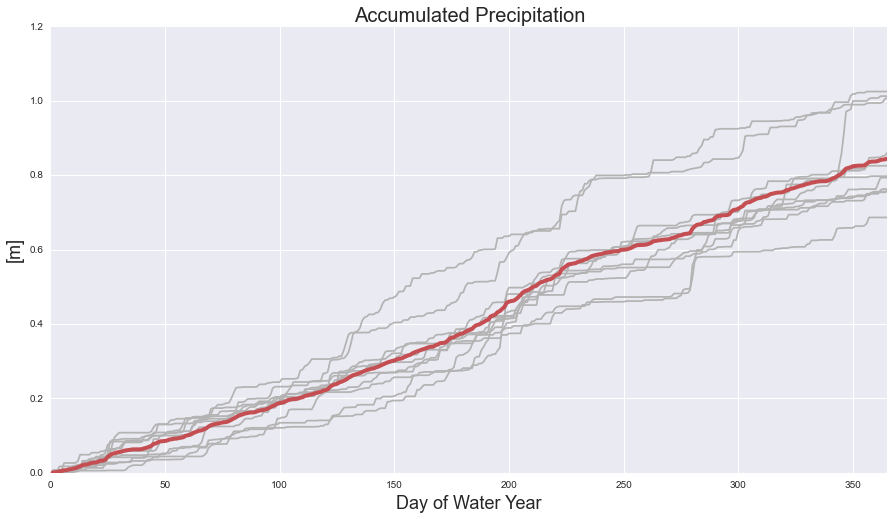

In [26]:
plt.figure(figsize=(15,8))
for wy in np.unique(crn.wateryear):
    plt.plot(crn.loc[crn.wateryear==wy,'DOWY'],crn.loc[crn.wateryear==wy,'accumP'],'-',c='0.7')
plt.plot(crn2.index,crn2.accumP,lw=4, c= colors[2])
plt.xlim(0,365)
plt.title('Accumulated Precipitation',fontsize = 20)
plt.ylabel('[m]', fontsize=18)
plt.xlabel('Day of Water Year', fontsize=18)
plt.savefig('./figures/mean_precip.png',dpi=300,bbox_inches='tight')

## Create a Mean Nievograph

In [20]:
# do something about leap years...
niwot.loc[niwot.DOWY==366] = np.NaN # set this equal to nan
niwot.dropna(inplace=True) # and delete it

In [21]:
niwot2 = niwot.groupby(by='DOWY').mean()

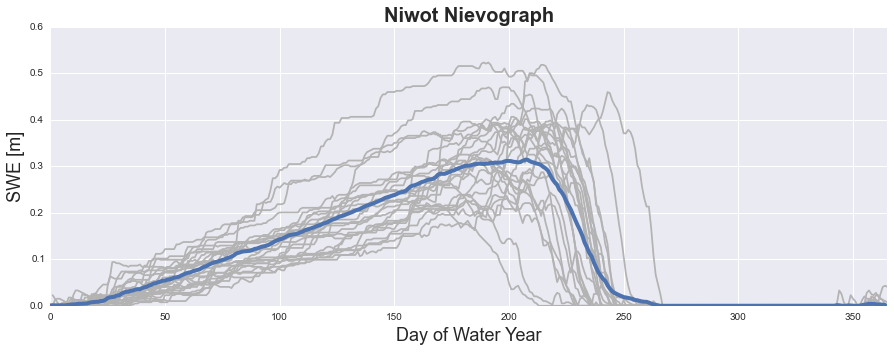

In [30]:
plt.figure(figsize=(15,5))
for wy in np.unique(niwot.wateryear):
    plt.plot(niwot.loc[niwot.wateryear==wy,'DOWY'],niwot.loc[niwot.wateryear==wy,'swe'],'-',c='0.7')
plt.plot(niwot2.swe,lw=4, c=colors[0])
plt.xlim(0,365)
plt.xlabel('Day of Water Year', fontsize=18)
plt.ylabel('SWE [m]', fontsize = 18)
plt.title('Niwot Nievograph', fontsize=20, fontweight='bold')
plt.savefig('./figures/mean_swe.png',dpi=300,bbox_inches='tight')

## Average Snowmelt Rate

In [28]:
peakswe = np.max(niwot2.swe)
dowypeakswe = list(niwot2.loc[niwot2.swe==peakswe].index)[0]
dowysnowfree = niwot2.swe.argmin()
ablseas = dowysnowfree-dowypeakswe

5.42 mm/day


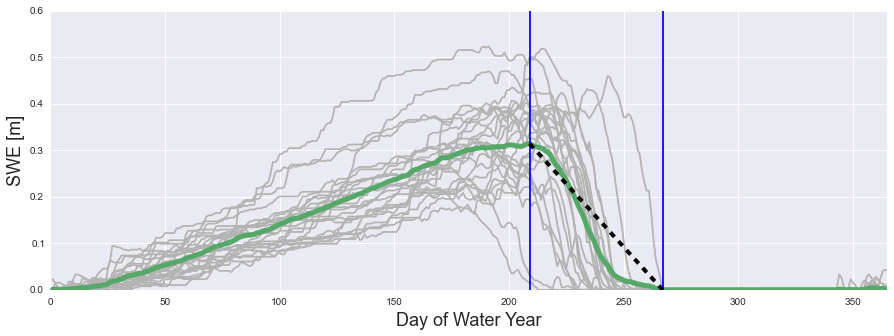

In [31]:
plt.figure(figsize=(15,5))
for wy in np.unique(niwot.wateryear):
    plt.plot(niwot.loc[niwot.wateryear==wy,'DOWY'],niwot.loc[niwot.wateryear==wy,'swe'],'-',c='0.7')
plt.plot(niwot2.index,niwot2.swe,lw=5)
plt.xlim(0,365)
plt.xlabel('Day of Water Year', fontsize=18)
plt.ylabel('SWE [m]',fontsize=18)
plt.axvline(dowypeakswe)
plt.axvline(dowysnowfree)
plt.plot([dowypeakswe,dowysnowfree],[peakswe,0],'--k',lw=4)
print round((peakswe/ablseas)*1000,2),'mm/day'
plt.savefig('./figures/mean_snowmelt.png',dpi=300,bbox_inches='tight')

## Snowmelt Scenarios

### Timing Shift:
Move T$_{peakswe}$ and T$_{snowfree}$ by equal ammount to hold the melt rate constant.

### Magnitude / Rate Shift:
Increase Peak SWE and maintain timing.

### Combination
Shift up timing and increase Peak SWE or keep timing and increase peak SWE while maintaining a given snowmelt rate.


In [33]:
# compute snowmelt
sn1 = niwot2.swe.as_matrix()[0:-1] # grab the first through the 2nd to last measurement
sn2 = niwot2.swe.as_matrix()[1:] # grab the second through the last measurement

sm = sn1-sn2 # compute melt
sm = np.concatenate([sm,[0]],axis=1)

niwot2['snowmelt'] = sm

In [34]:
niwot2.loc[niwot2.snowmelt < 0,'snowmelt'] = 0. # set accumulation events to zero

In [35]:
niwot2['accumSM'] = niwot2.snowmelt.cumsum()

In [36]:
niwot2.snowmelt.describe()

count    365.000000
mean       0.000893
std        0.002584
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.015037
Name: snowmelt, dtype: float64

5.42 mm/day


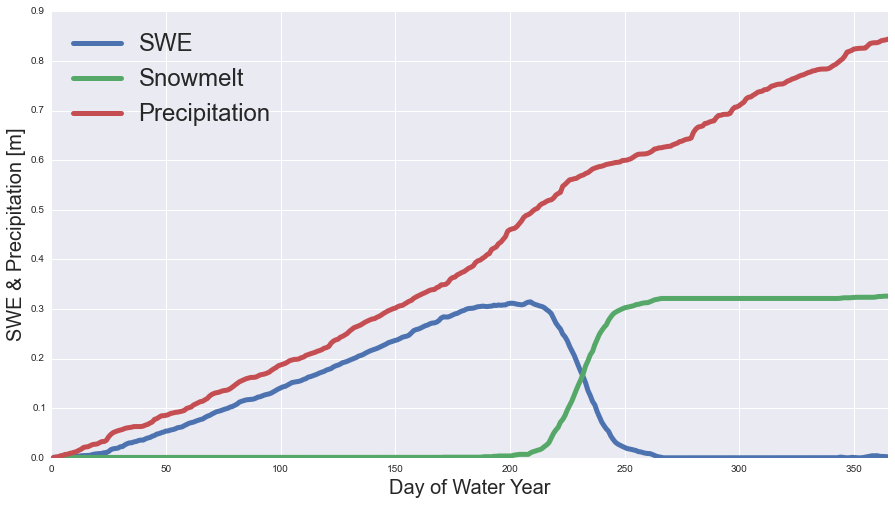

In [40]:
plt.figure(figsize=(15,8))
plt.plot(niwot2.index,niwot2.swe,lw=5)
plt.plot(niwot2.index,niwot2.accumSM,lw=5)
plt.plot(crn2.index,crn2.accumP,lw=5)
plt.xlim(0,365)
plt.xlabel('Day of Water Year', fontsize=20)
plt.ylabel('SWE & Precipitation [m]', fontsize=20)
plt.legend(['SWE','Snowmelt','Precipitation'],loc='best',fontsize=24)
#plt.axvline(dowypeakswe)
#plt.axvline(dowysnowfree)
#plt.plot([dowypeakswe,dowysnowfree],[peakswe,0],'--k')
print round((peakswe/ablseas)*1000,2),'mm/day'

In [41]:
P = pd.DataFrame(crn2.P.copy()) # precip only
Pcomb = P.copy() # the combined P + snowmelt signal

P.loc[0:dowypeakswe,'P'] = 0 # zero the P up until Peak SWE
Pcomb.loc[0:dowypeakswe,'P'] = 0 # zero the P up until Peak SWE
Pcomb.loc[dowypeakswe+1:dowysnowfree+1,'P'] += niwot2.loc[dowypeakswe+1:dowysnowfree+1,'snowmelt'] # make a composite P + snowmelt record


P['accumP'] = P.P.cumsum()
Pcomb['accumP'] = Pcomb.P.cumsum()

5.42 mm/day


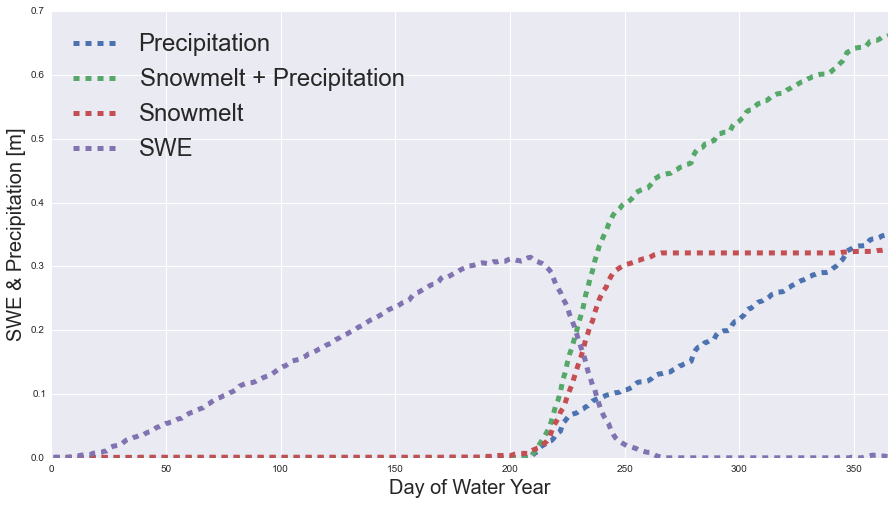

In [50]:
plt.figure(figsize=(15,8))
plt.plot(P.index,P.accumP,'--',lw=5)
plt.plot(Pcomb.index,Pcomb.accumP,'--',lw=5)
plt.plot(niwot2.index,niwot2.accumSM,'--',lw=5)

plt.plot(niwot2.index,niwot2.swe,'--',lw=5)

plt.xlim(0,365)
plt.xlabel('Day of Water Year', fontsize=20)
plt.ylabel('SWE & Precipitation [m]', fontsize=20)
plt.legend(['Precipitation','Snowmelt + Precipitation','Snowmelt','SWE'],loc='best',fontsize=24)

plt.savefig('./figures/control_scenario.png',dpi=300,bbox_inches='tight')

print round((peakswe/ablseas)*1000,2),'mm/day'

## Increase both P and Snow by 50%

In [52]:
ic = 1.5 # increase by 20%
P1 = pd.DataFrame(crn2.P) # precip only
Pcomb1 = P.copy() # the combined P + snowmelt signal

P1.loc[0:dowypeakswe,'P'] = 0 # zero the P up until Peak SWE
Pcomb1.loc[0:dowypeakswe,'P'] = 0 # zero the P up until Peak SWE
Pcomb1['P'] *= ic # apply the increase
P1['P'] *= ic # apply the increase
Pcomb1.loc[dowypeakswe+1:dowysnowfree+1,'P'] += (niwot2.loc[dowypeakswe+1:dowysnowfree+1,'snowmelt']*ic) # make a composite P + snowmelt record

P1['accumP'] = P1.P.cumsum()
Pcomb1['accumP'] = Pcomb1.P.cumsum()

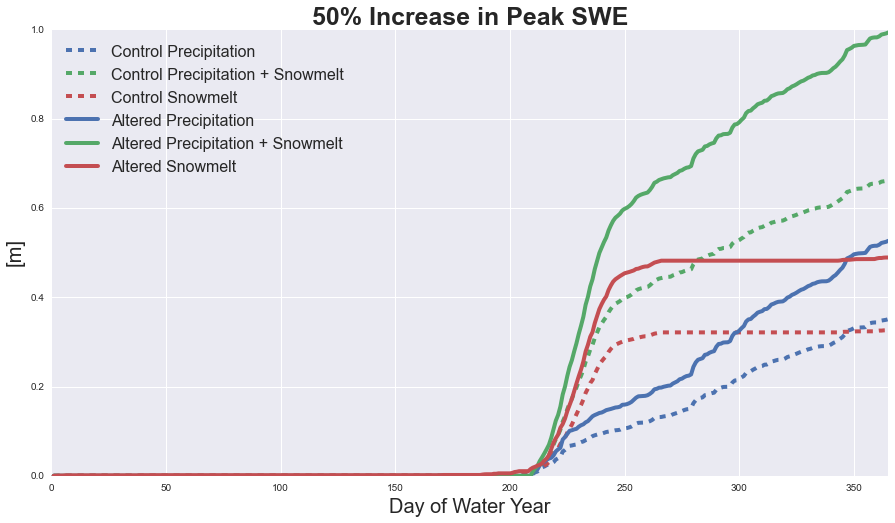

In [54]:
plt.figure(figsize=(15,8))
plt.plot(P.index,P.accumP,'--',lw=4,c = colors[0])
plt.plot(Pcomb.index,Pcomb.accumP,'--',lw=4,c = colors[1])
plt.plot(niwot2.index,niwot2.accumSM,'--',lw=4,c = colors[2])

plt.plot(P1.index,P1.accumP,'-',lw=4,c = colors[0])
plt.plot(Pcomb1.index,Pcomb1.accumP,'-',lw=4,c = colors[1])
plt.plot(niwot2.index,niwot2.accumSM*ic,'-',lw=4,c = colors[2])


names= ['Control Precipitation','Control Precipitation + Snowmelt','Control Snowmelt',
        'Altered Precipitation','Altered Precipitation + Snowmelt','Altered Snowmelt']
plt.legend(names,fontsize=16,loc='best')
plt.xlim(0,365)
plt.title('50% Increase in Peak SWE', fontsize = 25, fontweight = 'bold')
plt.xlabel('Day of Water Year', fontsize=20)
plt.ylabel('[m]',fontsize=20)
plt.savefig('./figures/increase_peak_swe.png',dpi=300,bbox_inches='tight')

## Explore A shift in Timing

In [60]:
ic = 1.0 # increase by 20%
shift = -21.
P2 = pd.DataFrame(crn2.P.copy()) # precip only
Pcomb2 = P2.copy() # the combined P + snowmelt signal
S2 = pd.DataFrame(niwot2.snowmelt.copy())
S2['snowmelt'] = 0. 

P2.loc[0:dowypeakswe+shift,'P'] = 0 # zero the P up until Peak SWE
Pcomb2.loc[0:dowypeakswe+shift,'P'] = 0 # zero the P up until Peak SWE
Pcomb2['P'] *= ic # apply the increase
P2['P'] *= ic # apply the increase
Pcomb2.loc[dowypeakswe+1+shift:dowysnowfree+1+shift,'P'] += niwot2.loc[dowypeakswe+1:dowysnowfree+1,'snowmelt'].as_matrix()*ic # make a composite P + snowmelt record
S2.loc[dowypeakswe+1+shift:dowysnowfree+1+shift,'snowmelt'] = niwot2.loc[dowypeakswe+1:dowysnowfree+1,'snowmelt'].as_matrix()*ic

P2['accumP'] = P2.P.cumsum()
Pcomb2['accumP'] = Pcomb2.P.cumsum()
S2['accumSM'] = S2.snowmelt.cumsum()

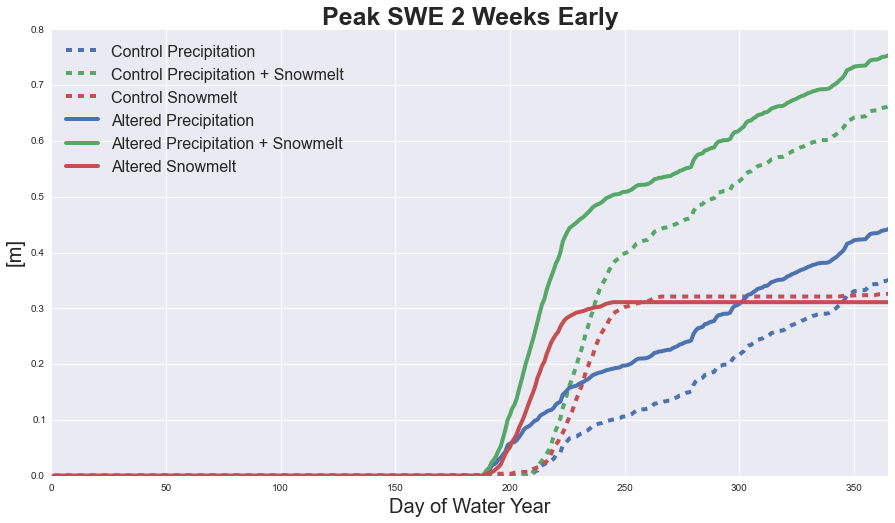

In [61]:
plt.figure(figsize=(15,8))
plt.plot(P.index,P.accumP,'--',lw=4,c = colors[0])
plt.plot(Pcomb.index,Pcomb.accumP,'--',lw=4,c = colors[1])
plt.plot(niwot2.index,niwot2.accumSM,'--',lw=4,c = colors[2])

plt.plot(P2.index,P2.accumP,'-',lw=4,c = colors[0])
plt.plot(Pcomb2.index,Pcomb2.accumP,'-',lw=4,c = colors[1])
plt.plot(S2.index,S2.accumSM,'-',lw=4,c = colors[2])


names= ['Control Precipitation','Control Precipitation + Snowmelt','Control Snowmelt',
        'Altered Precipitation','Altered Precipitation + Snowmelt','Altered Snowmelt']
plt.legend(names,fontsize=16,loc='best')
plt.xlim(0,365)
plt.title('Peak SWE 2 Weeks Early', fontsize = 25, fontweight = 'bold')
plt.xlabel('Day of Water Year', fontsize=20)
plt.ylabel('[m]',fontsize=20)
plt.savefig('./figures/early_peak_swe.png',dpi=300,bbox_inches='tight')

## Explore both a time shift and magnitude shift

In [57]:
ic = 1.5 # increase by 20%
shift = -28.
P2 = pd.DataFrame(crn2.P.copy()) # precip only
Pcomb2 = P2.copy() # the combined P + snowmelt signal
S2 = pd.DataFrame(niwot2.snowmelt.copy())
S2['snowmelt'] = 0. 

P2.loc[0:dowypeakswe+shift,'P'] = 0 # zero the P up until Peak SWE
Pcomb2.loc[0:dowypeakswe+shift,'P'] = 0 # zero the P up until Peak SWE
Pcomb2['P'] *= ic # apply the increase
P2['P'] *= ic # apply the increase
Pcomb2.loc[dowypeakswe+1+shift:dowysnowfree+1+shift,'P'] += niwot2.loc[dowypeakswe+1:dowysnowfree+1,'snowmelt'].as_matrix()*ic # make a composite P + snowmelt record
S2.loc[dowypeakswe+1+shift:dowysnowfree+1+shift,'snowmelt'] = niwot2.loc[dowypeakswe+1:dowysnowfree+1,'snowmelt'].as_matrix()*ic

P2['accumP'] = P2.P.cumsum()
Pcomb2['accumP'] = Pcomb2.P.cumsum()
S2['accumSM'] = S2.snowmelt.cumsum()

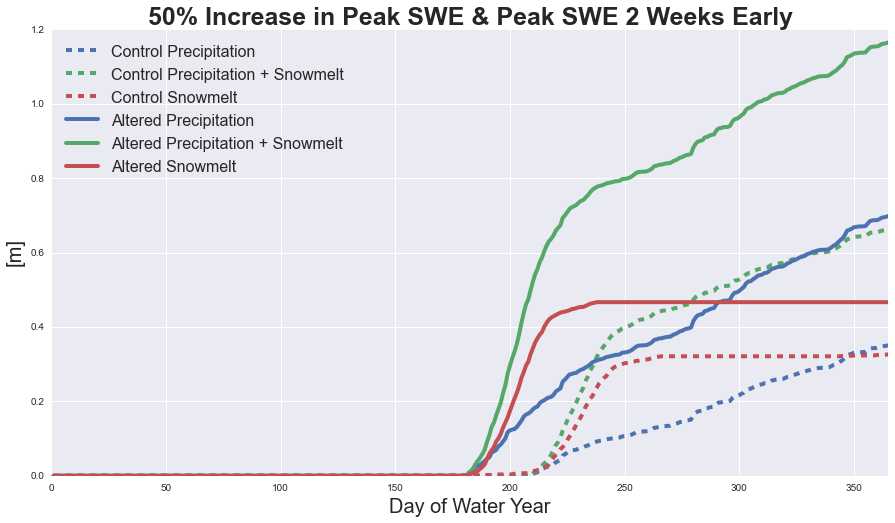

In [59]:
plt.figure(figsize=(15,8))
plt.plot(P.index,P.accumP,'--',lw=4,c = colors[0])
plt.plot(Pcomb.index,Pcomb.accumP,'--',lw=4,c = colors[1])
plt.plot(niwot2.index,niwot2.accumSM,'--',lw=4,c = colors[2])

plt.plot(P2.index,P2.accumP,'-',lw=4,c = colors[0])
plt.plot(Pcomb2.index,Pcomb2.accumP,'-',lw=4,c = colors[1])
plt.plot(S2.index,S2.accumSM,'-',lw=4,c = colors[2])

names= ['Control Precipitation','Control Precipitation + Snowmelt','Control Snowmelt',
        'Altered Precipitation','Altered Precipitation + Snowmelt','Altered Snowmelt']
plt.legend(names,fontsize=16,loc='best')
plt.xlim(0,365)
plt.title('50% Increase in Peak SWE & Peak SWE 2 Weeks Early ', fontsize = 25, fontweight = 'bold');
plt.xlabel('Day of Water Year', fontsize=20)
plt.ylabel('[m]',fontsize=20)
plt.savefig('./figures/combo.png',dpi=300,bbox_inches='tight')

## No Snow

In [64]:
ic = 1.0 # increase by 20%
shift = 0.
P2 = pd.DataFrame(crn2.P.copy()) # precip only
Pcomb2 = P2.copy() # the combined P + snowmelt signal
S2 = pd.DataFrame(niwot2.snowmelt.copy())
S2['snowmelt'] = 0. 

#P2.loc[0:dowypeakswe+shift,'P'] = 0 # zero the P up until Peak SWE
#Pcomb2.loc[0:dowypeakswe+shift,'P'] = 0 # zero the P up until Peak SWE
Pcomb2['P'] *= ic # apply the increase
P2['P'] *= ic # apply the increase
#Pcomb2.loc[dowypeakswe+1+shift:dowysnowfree+1+shift,'P'] += niwot2.loc[dowypeakswe+1:dowysnowfree+1,'snowmelt'].as_matrix()*ic # make a composite P + snowmelt record
#S2.loc[dowypeakswe+1+shift:dowysnowfree+1+shift,'snowmelt'] = niwot2.loc[dowypeakswe+1:dowysnowfree+1,'snowmelt'].as_matrix()*ic

P2['accumP'] = P2.P.cumsum()
Pcomb2['accumP'] = Pcomb2.P.cumsum()
S2['accumSM'] = S2.snowmelt.cumsum()

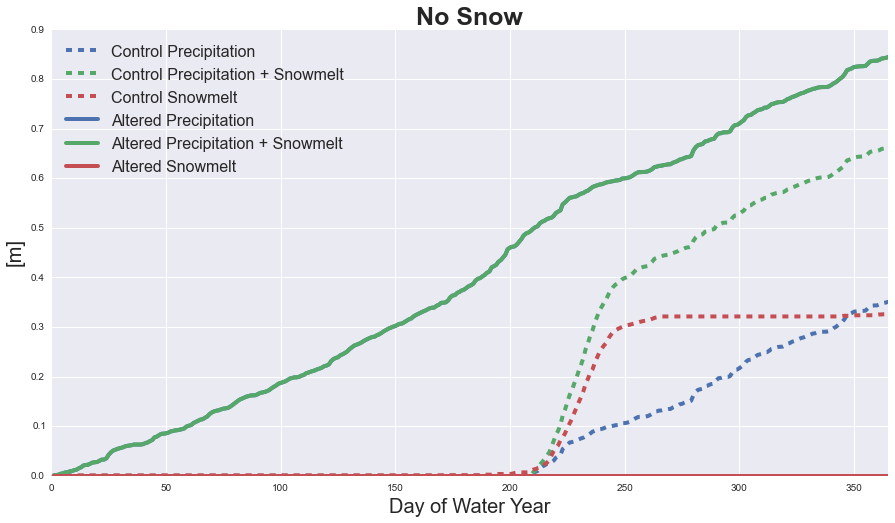

In [65]:
plt.figure(figsize=(15,8))
plt.plot(P.index,P.accumP,'--',lw=4,c = colors[0])
plt.plot(Pcomb.index,Pcomb.accumP,'--',lw=4,c = colors[1])
plt.plot(niwot2.index,niwot2.accumSM,'--',lw=4,c = colors[2])

plt.plot(P2.index,P2.accumP,'-',lw=4,c = colors[0])
plt.plot(Pcomb2.index,Pcomb2.accumP,'-',lw=4,c = colors[1])
plt.plot(S2.index,S2.accumSM,'-',lw=4,c = colors[2])

names= ['Control Precipitation','Control Precipitation + Snowmelt','Control Snowmelt',
        'Altered Precipitation','Altered Precipitation + Snowmelt','Altered Snowmelt']
plt.legend(names,fontsize=16,loc='best')
plt.xlim(0,365)
plt.title('No Snow', fontsize = 25, fontweight = 'bold');
plt.xlabel('Day of Water Year', fontsize=20)
plt.ylabel('[m]',fontsize=20)
plt.savefig('./figures/no_snow.png',dpi=300,bbox_inches='tight')

In [39]:
S2 = pd.DataFrame(niwot2.snowmelt.copy())
S2['snowmelt'] = 0. 

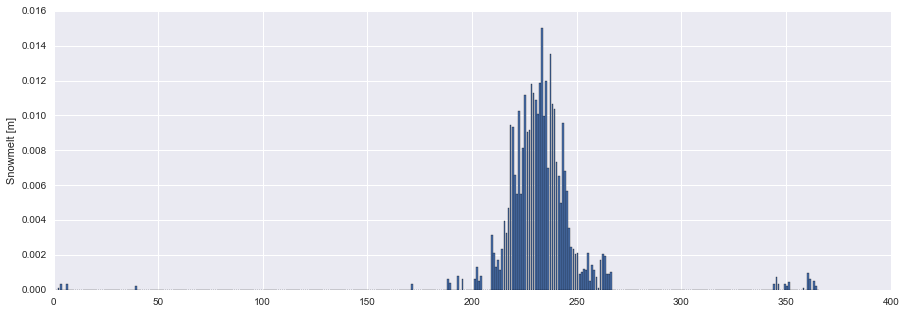

In [76]:
plt.figure(figsize=(15,5))
plt.bar(niwot2.index,niwot2.snowmelt)
plt.ylabel('Snowmelt [m]')

1.66527473459


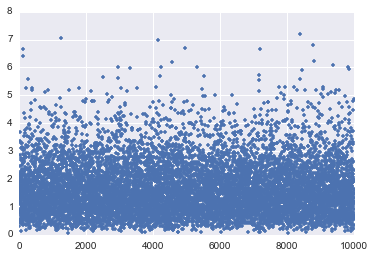

In [51]:
n = 10000

mean = 5.42 # [mm/d]
k = 3.
beta = mean/k
theta = 1/beta

tmp = np.random.gamma(k,theta,n)

plt.plot(tmp,'.')
print np.mean(tmp)

In [46]:
S2.loc[dowypeakswe+1+shift:dowysnowfree+1+shift,'snowmelt']

DOWY
182         NaN
183         NaN
184         NaN
185         NaN
186         NaN
187         NaN
188         NaN
189         NaN
190         NaN
191         NaN
192         NaN
193         NaN
194         NaN
195         NaN
196         NaN
197         NaN
198         NaN
199         NaN
200         NaN
201         NaN
202         NaN
203         NaN
204         NaN
205         NaN
206         NaN
207         NaN
208         NaN
209         NaN
210    0.002134
211    0.001321
212    0.001727
213    0.001118
214    0.002337
215    0.003962
216    0.003251
217    0.004674
218    0.009449
219    0.009347
220    0.006604
221    0.005486
222    0.010262
223    0.005486
224    0.008128
225    0.011176
226    0.009042
227    0.009144
228    0.011786
229    0.011278
230    0.010871
231    0.010058
232    0.011887
233    0.015037
234    0.009957
235    0.011989
236    0.007010
237    0.013513
238    0.010668
239    0.010363
240    0.007315
Name: snowmelt, dtype: float64